In [2]:
import numpy as np
import torch
import torch.nn as nn
import h5py as h5
import os
import sys
import pickle
sys.path.append("../")
from models import PracticalBNCNN, NormedBNCNN, DalesBNCNN, DalesSSCNN, SSCNN, BNCNN, PracticalBNCNN, DalesHybrid, DalesSkipBNCNN, SkipBNBNCNN
#import metrics
import matplotlib.pyplot as plt
from utils.deepretina_loader import loadexpt
from utils.physiology import Physio
import utils.intracellular as intracellular
import utils.batch_compute as bc
import utils.retinal_phenomena as rp
import utils.stimuli as stimuli
import pyret.filtertools as ft
import scipy
import re
import pickle
from tqdm import tqdm
import gc
import resource
import time
import math

def normalize(x):
    return (x-x.mean())/(x.std()+1e-7)

def retinal_phenomena_figs(bn_cnn):
    rp.step_response(bn_cnn)
    rp.osr(bn_cnn)
    rp.reversing_grating(bn_cnn)
    rp.contrast_adaptation(bn_cnn, .35, .05)
    rp.motion_anticipation(bn_cnn)
    
#If you want to use stimulus that isnt just boxes
def prepare_stim(stim, stim_type):
    if stim_type == 'boxes':
        return 2*stim - 1
    elif stim_type == 'flashes':
        stim = stim.reshape(stim.shape[0], 1, 1)
        return np.broadcast_to(stim, (stim.shape[0], 38, 38))
    elif stim_type == 'movingbar':
        stim = block_reduce(stim, (1,6), func=np.mean)
        stim = pyret.stimulustools.upsample(stim.reshape(stim.shape[0], stim.shape[1], 1), 5)[0]
        return np.broadcast_to(stim, (stim.shape[0], stim.shape[1], stim.shape[1]))
    elif stim_type == 'lines':
        stim_averaged = np.apply_along_axis(lambda m: np.convolve(m, 0.5*np.ones((2,)), mode='same'), 
                                            axis=1, arr=stim)
        stim = stim_averaged[:,::2]
        # now stack stimulus to convert 1d to 2d spatial stimulus
        return stim.reshape(-1,1,stim.shape[-1]).repeat(stim.shape[-1], axis=1)
    else:
        print("Invalid stim type")
        assert False
    
def index_of(arg, arr):
    for i in range(len(arr)):
        if arg == arr[i]:
            return i
    return -1

In [3]:
DEVICE = torch.device("cuda:0")
torch.cuda.empty_cache()

In [4]:
#Load data
# num_pots stores the number of cells per stimulus
# mem_pots stores the membrane potential
# psst, you can find the "data" folder in /home/grantsrb on deepretina server
# psssst, note the additional ../ added to each path in files

files = ['../data/bipolars_late_2012.h5', '../data/bipolars_early_2012.h5', '../data/amacrines_early_2012.h5', '../data/amacrines_late_2012.h5', '../data/horizontals_early_2012.h5', '../data/horizontals_late_2012.h5']
files = ["../" + name for name in files]
file_ids = []
for f in files:
    file_ids.append(re.split('_|\.', f)[0])
filter_length = 40
window_size = 2
num_pots = []
stims = dict()
mem_pots = dict()
keys_to_use = {"boxes"}
for fi in files:
    with h5.File(fi, 'r') as f:
        for k in f.keys():
            if k in keys_to_use:
                if k not in stims:
                    stims[k] = []
                if k not in mem_pots:
                    mem_pots[k] = []
                try:
                    stims[k].append(prepare_stim(np.asarray(f[k+'/stimuli']), k))
                    mem_pots[k].append(np.asarray(f[k]['detrended_membrane_potential'])[:, filter_length:])
                except:
                    print("stim error at", k)
        num = np.array(f['boxes/detrended_membrane_potential'].shape[0])
        num_pots.append(num)

In [10]:
grand_folder = "bncnnDataSearch"
exp_folder = "../training_scripts/"+grand_folder
_, model_folders, _ = next(os.walk(exp_folder))
for i,f in enumerate(model_folders):
    model_folders[i] = grand_folder + "/" + f

In [11]:
model_folders = sorted(model_folders, key=lambda x: (x.split("dataset")[-1].split("_")[0], x.split("stim_type")[-1]))
print("\n".join(model_folders))

bncnnDataSearch/bncnnDataSearch_0_dataset15-10-07_stim_typewhitenoise
bncnnDataSearch/bncnnDataSearch_4_dataset15-11-21b_stim_typewhitenoise
bncnnDataSearch/bncnnDataSearch_5_dataset15-11-21b_stim_typenaturalscene
bncnnDataSearch/bncnnDataSearch_2_dataset15-11-21a_stim_typewhitenoise
bncnnDataSearch/bncnnDataSearch_3_dataset15-11-21a_stim_typenaturalscene
bncnnDataSearch/bncnnDataSearch_1_dataset15-10-07_stim_typenaturalscene

bncnnDataSearch/bncnnDataSearch_1_dataset15-10-07_stim_typenaturalscene
bncnnDataSearch/bncnnDataSearch_0_dataset15-10-07_stim_typewhitenoise
bncnnDataSearch/bncnnDataSearch_3_dataset15-11-21a_stim_typenaturalscene
bncnnDataSearch/bncnnDataSearch_2_dataset15-11-21a_stim_typewhitenoise
bncnnDataSearch/bncnnDataSearch_5_dataset15-11-21b_stim_typenaturalscene
bncnnDataSearch/bncnnDataSearch_4_dataset15-11-21b_stim_typewhitenoise


In [6]:
file = "../training_scripts/"+model_folders[0]+"/test_epoch_0.pth"
try:
    with open(file, "rb") as fd:
        temp = torch.load(fd)
except:
    pass

temp['model']

BNCNN(
  (sequential): Sequential(
    (0): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False)
    (4): ReLU()
    (5): Reshape()
    (6): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
    (7): Flatten()
    (8): BatchNorm1d(5408, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (9): GaussianNoise(std=0.05, trainable=False)
    (10): ReLU()
    (11): Linear(in_features=5408, out_features=5, bias=True)
    (12): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Softplus(beta=1, threshold=20)
  )
)

In [7]:
conv_layers = ['sequential.2', 'sequential.8']

In [8]:
gc.collect()
max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory Used: {:.2f} mb".format(max_mem_used / 1024))

Memory Used: 2955.98 mb


## Look at model performances

Using layers: sequential.2 and sequential.8
Folder: bncnnDataSearch/bncnnDataSearch_0_dataset15-10-07_stim_typewhitenoise
Final Loss: -6.345135047964381
Final Val: -6.239952645559242
Final Val Acc: 0.28865116834640503

Final Test Acc: 0.710108315763339


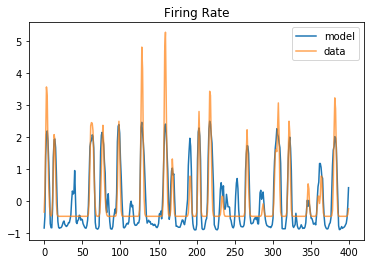

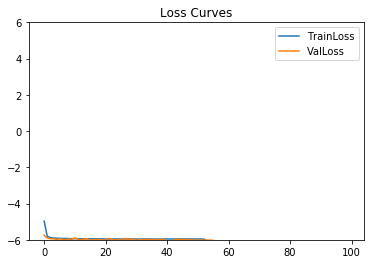

100%|██████████| 10/10 [00:00<00:00, 50.11it/s]
51it [00:00, 194.49it/s]


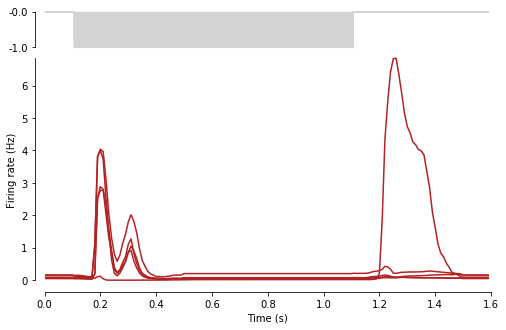

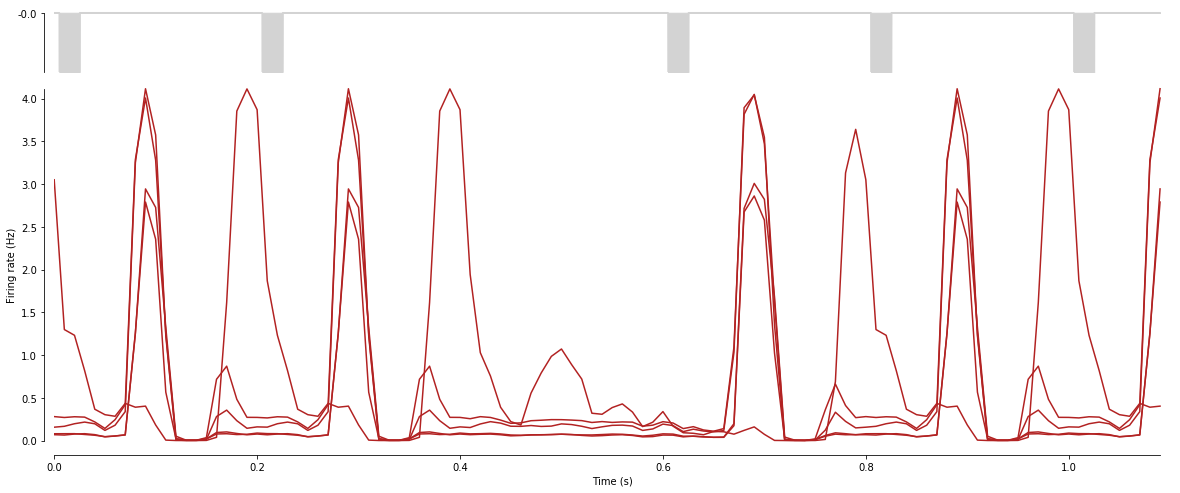

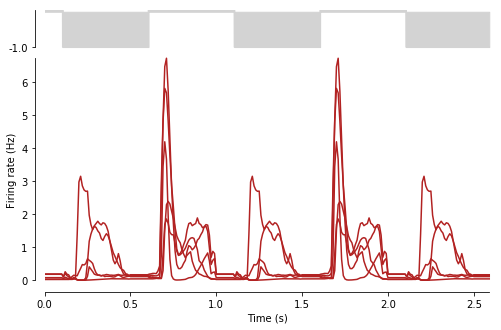

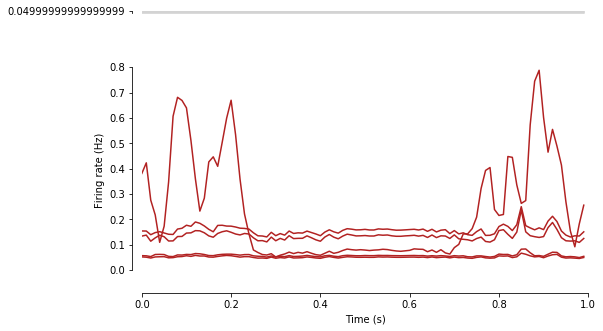

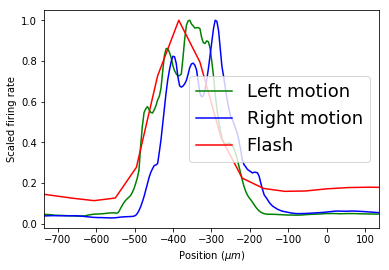

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:20<00:00, 23.53s/it]


Mean intracellular: 0.3931215212157214
Std intracellular: 0.1383686113050928
Min intracellular: 0.11147232917346339
Max intracellular: 0.6089647691862174
Layer sequential.2 correlation map


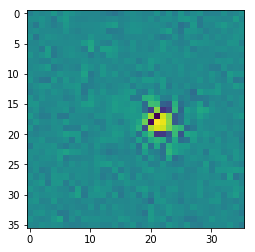

bipolar


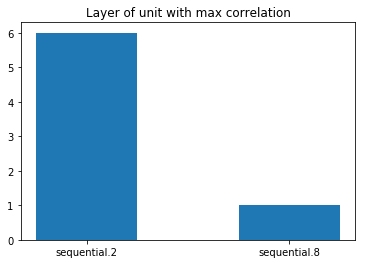

amacrine


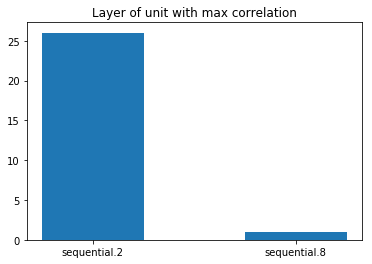

horizontal


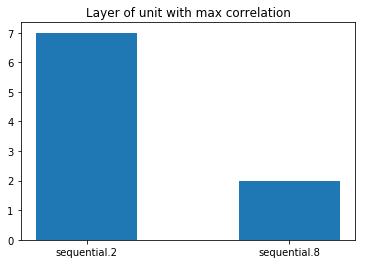

Receptive field of boxes model cell in Layer 0


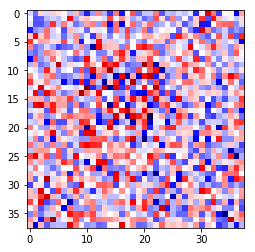

Receptive field of boxes model cell in Layer 1


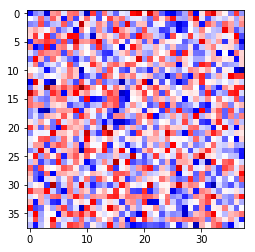

Memory Used: 7840.34 memory
Completed in 172.8155734539032 seconds





Folder: bncnnDataSearch/bncnnDataSearch_1_dataset15-10-07_stim_typenaturalscene
Final Loss: -2.8738065580437087
Final Val: -2.8419340202381136
Final Val Acc: 0.263962921500206

Final Test Acc: 0.6005618335318751


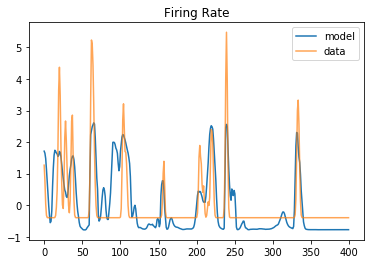

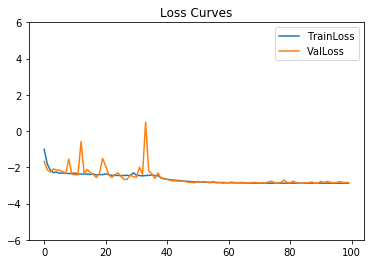

100%|██████████| 10/10 [00:00<00:00, 77.93it/s]
51it [00:00, 201.71it/s]


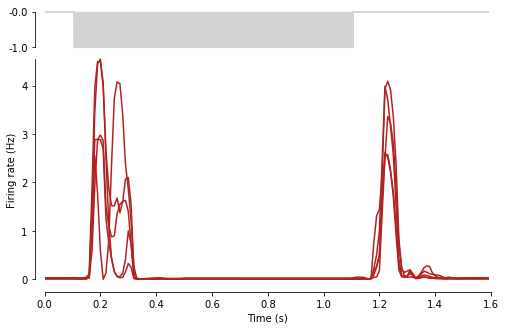

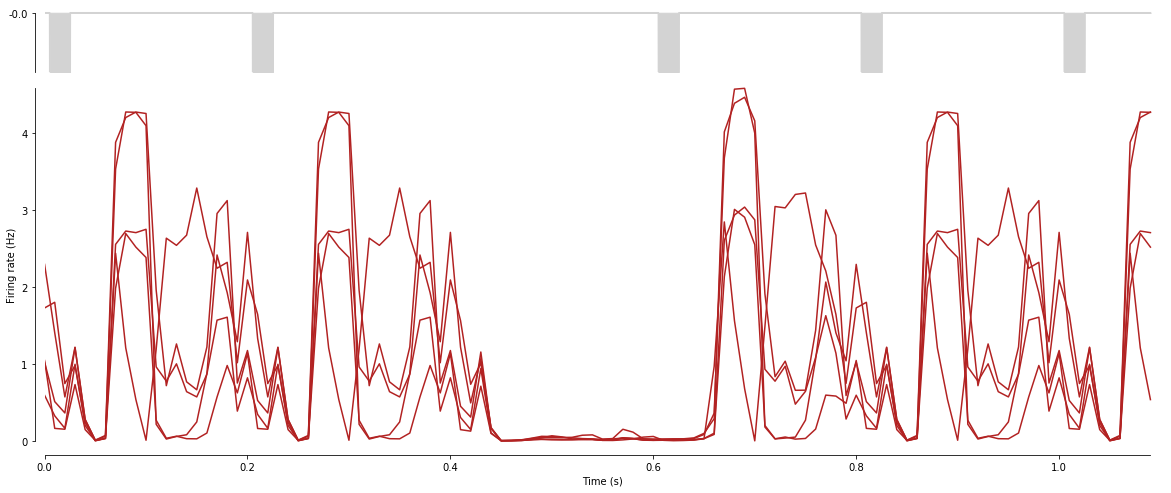

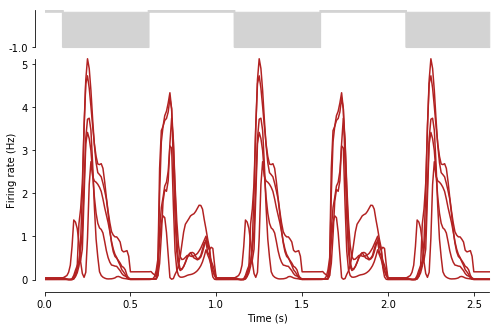

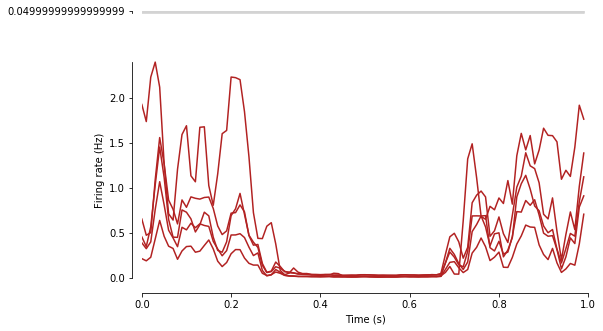

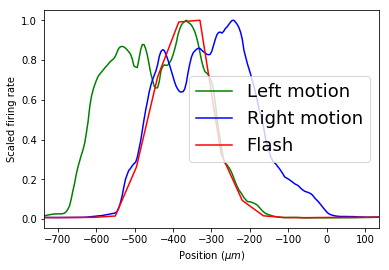

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:22<00:00, 23.89s/it]


Mean intracellular: 0.4251755735065839
Std intracellular: 0.13046915142810223
Min intracellular: 0.12301767201749418
Max intracellular: 0.6998710448606947
Layer sequential.2 correlation map


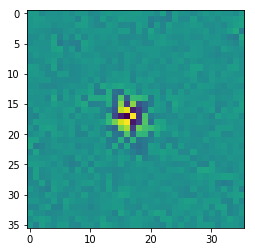

bipolar


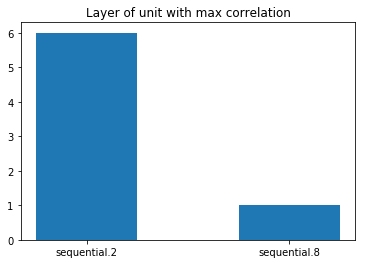

amacrine


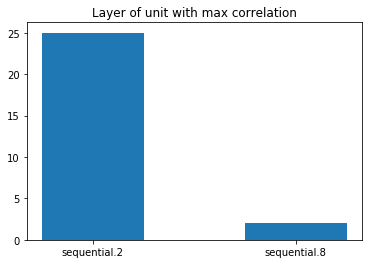

horizontal


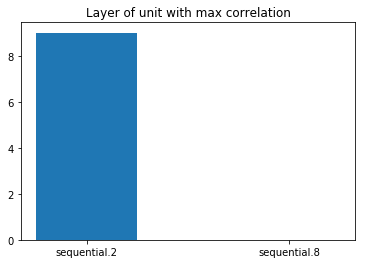

Receptive field of boxes model cell in Layer 0


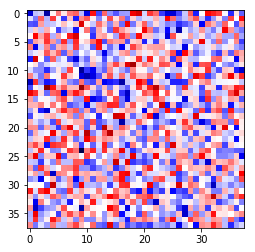

Receptive field of boxes model cell in Layer 1


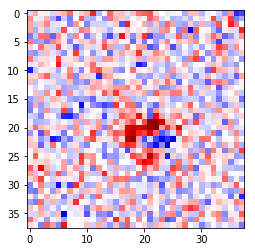

Memory Used: 8092.38 memory
Completed in 174.47982263565063 seconds





Folder: bncnnDataSearch/bncnnDataSearch_2_dataset15-11-21a_stim_typewhitenoise
Final Loss: -11.6005231453103
Final Val: -11.207152033275634
Final Val Acc: 0.2941647842526436

Final Test Acc: 0.6720275398049208


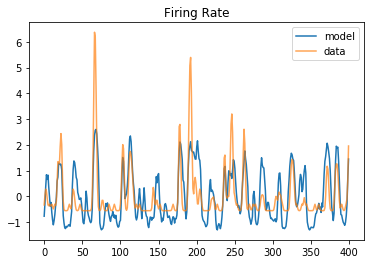

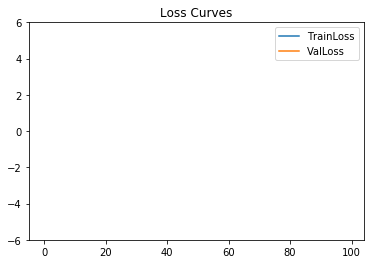

100%|██████████| 10/10 [00:00<00:00, 75.83it/s]
51it [00:00, 199.82it/s]


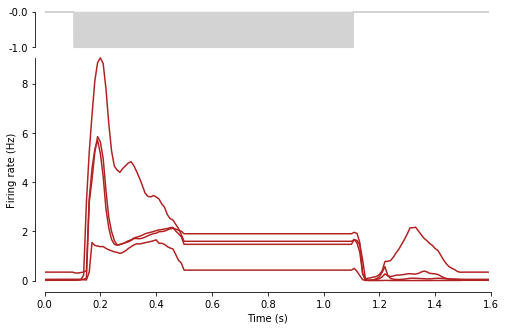

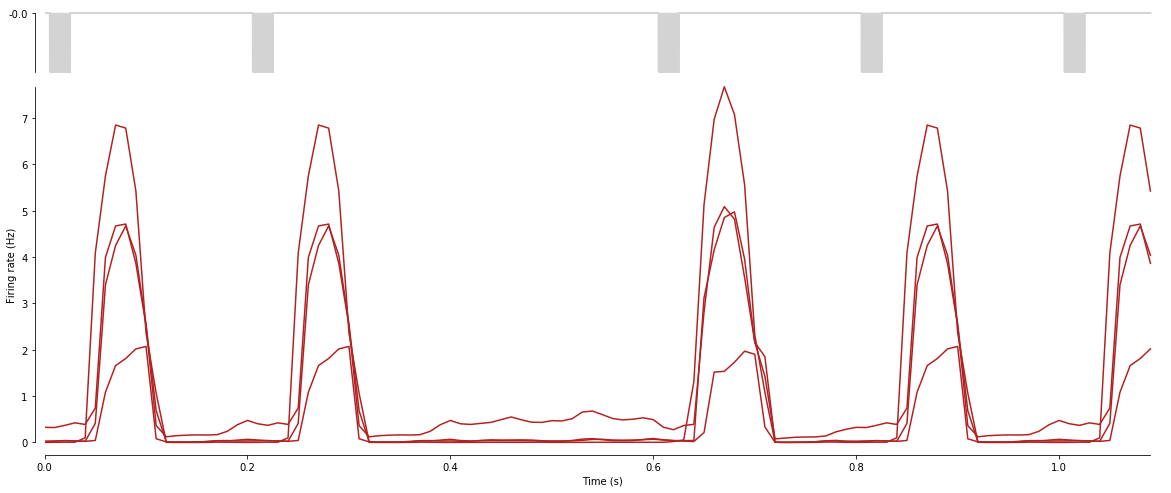

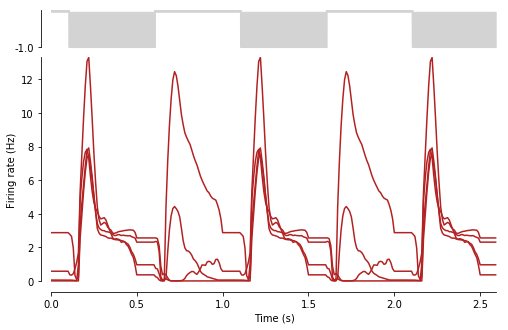

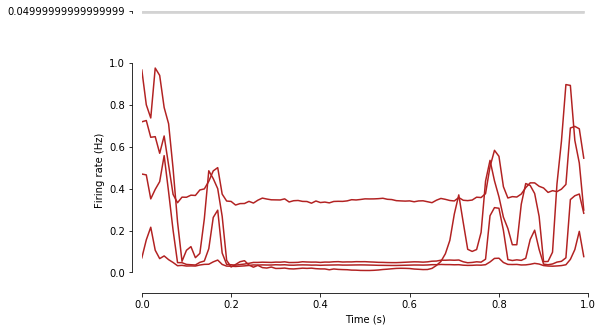

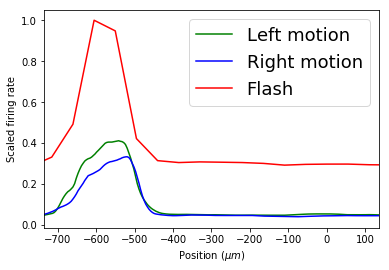

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:20<00:00, 23.49s/it]


Mean intracellular: 0.4959976343102039
Std intracellular: 0.11673178263471395
Min intracellular: 0.16516153649565843
Max intracellular: 0.7379224371937374
Layer sequential.2 correlation map


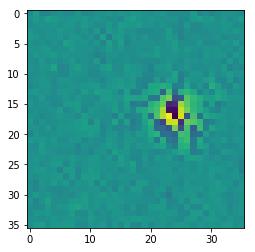

bipolar


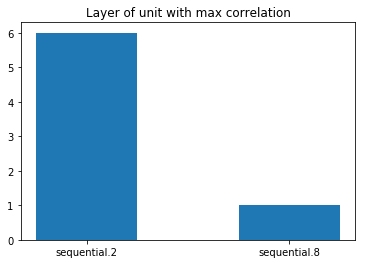

amacrine


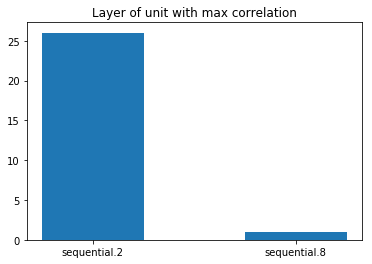

horizontal


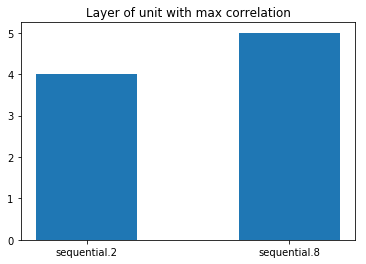

Receptive field of boxes model cell in Layer 0


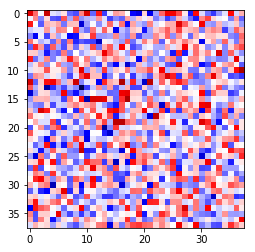

Receptive field of boxes model cell in Layer 1


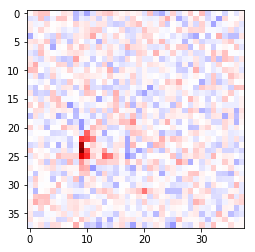

Memory Used: 8092.38 memory
Completed in 170.71991539001465 seconds





Folder: bncnnDataSearch/bncnnDataSearch_3_dataset15-11-21a_stim_typenaturalscene
Final Loss: -10.127384834519699
Final Val: -10.488153753798542
Final Val Acc: 0.29321836680173874

Final Test Acc: 0.6944496989703658


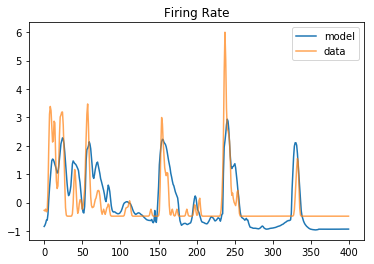

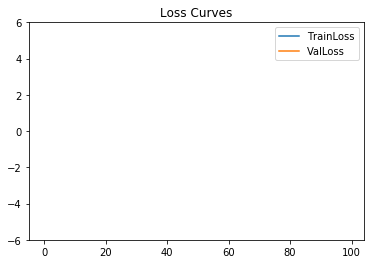

100%|██████████| 10/10 [00:00<00:00, 77.45it/s]
51it [00:00, 204.67it/s]


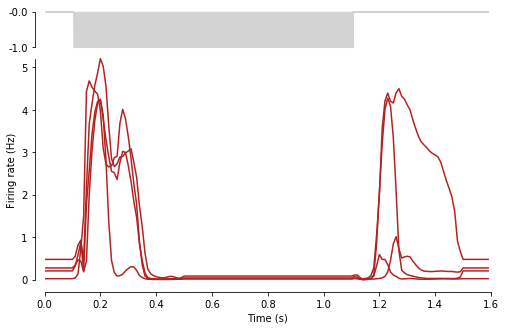

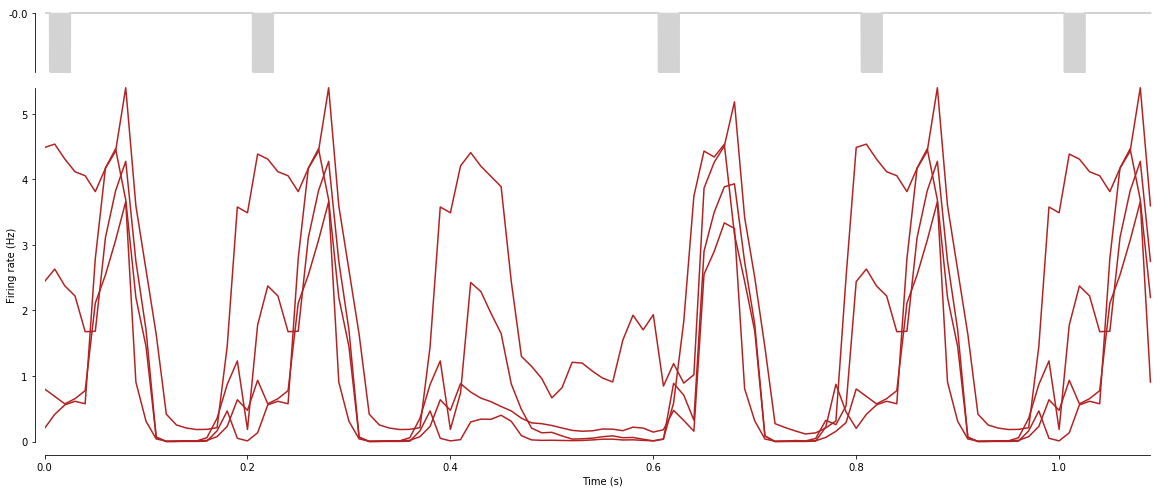

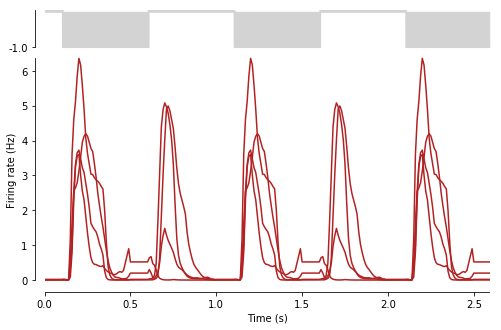

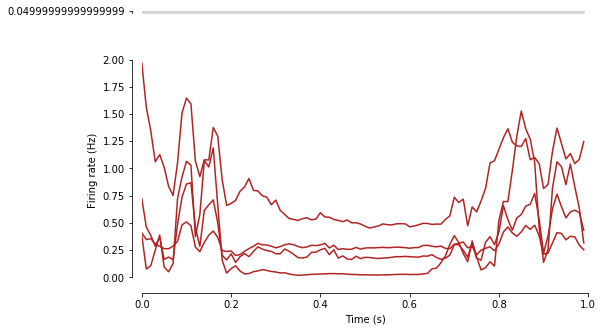

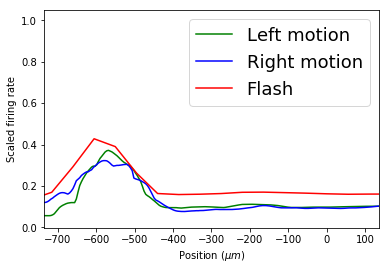

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:20<00:00, 23.48s/it]


Mean intracellular: 0.5337798085444823
Std intracellular: 0.14041939207079776
Min intracellular: 0.1930652143128745
Max intracellular: 0.7856839493455436
Layer sequential.2 correlation map


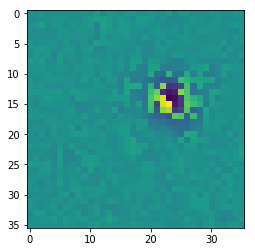

bipolar


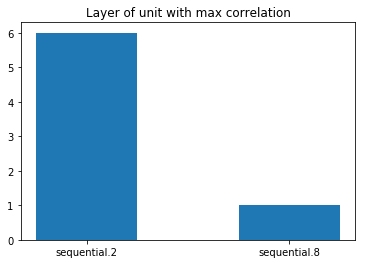

amacrine


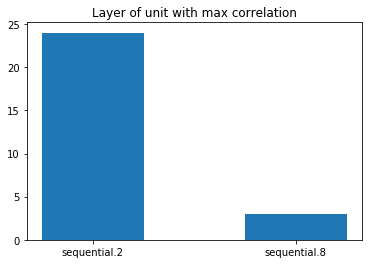

horizontal


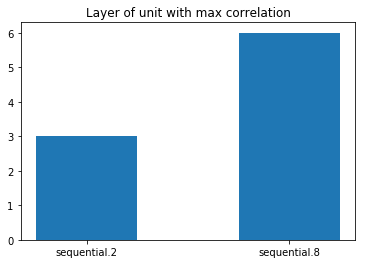

Receptive field of boxes model cell in Layer 0


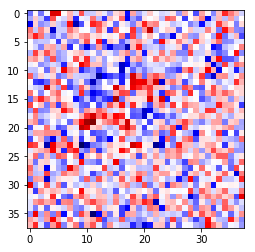

Receptive field of boxes model cell in Layer 1


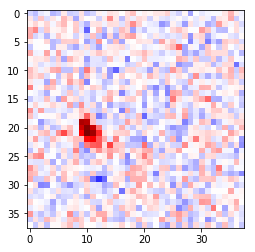

Memory Used: 8092.38 memory
Completed in 171.77093291282654 seconds





Folder: bncnnDataSearch/bncnnDataSearch_4_dataset15-11-21b_stim_typewhitenoise
Final Loss: -7.591547675442013
Final Val: -7.6157441219256725
Final Val Acc: 0.25304175299756665

Final Test Acc: 0.5386035418496716


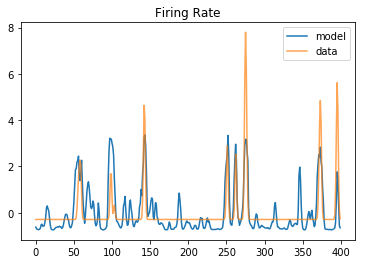

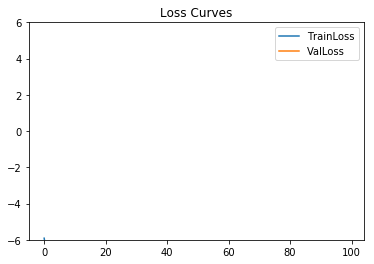

100%|██████████| 10/10 [00:00<00:00, 78.97it/s]
51it [00:00, 207.26it/s]


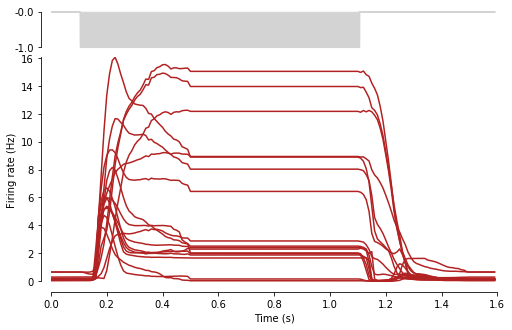

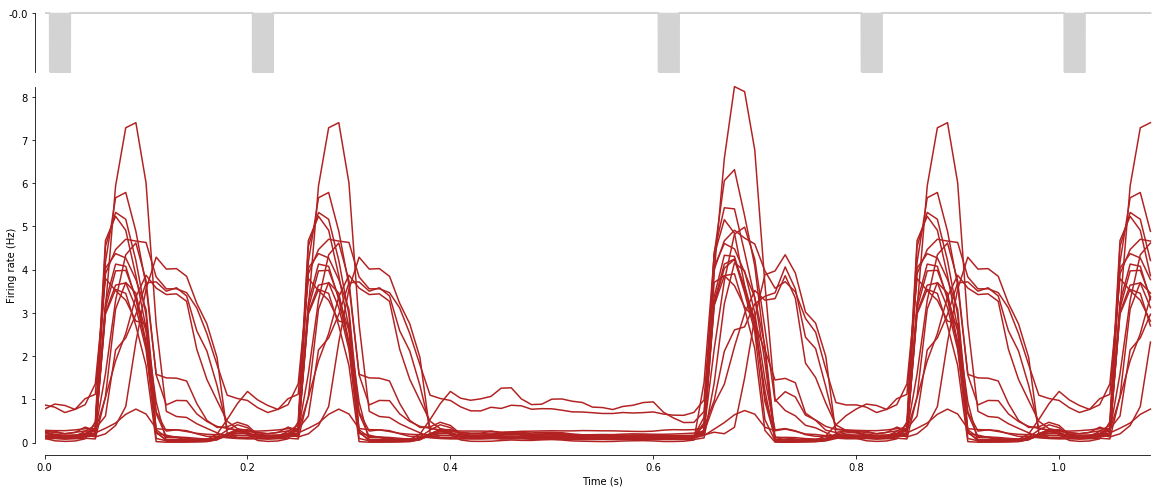

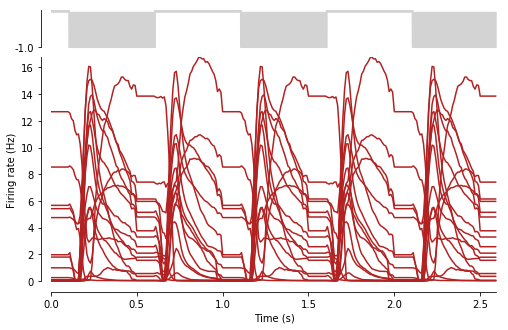

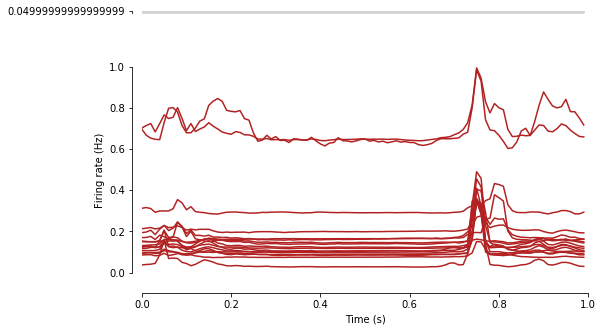

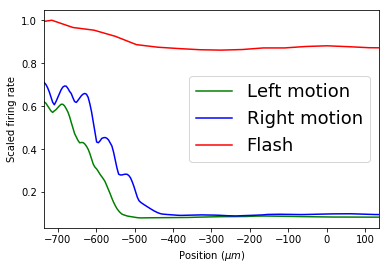

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:19<00:00, 23.37s/it]


Mean intracellular: 0.42343086136190417
Std intracellular: 0.11883839108478852
Min intracellular: 0.13512096186734995
Max intracellular: 0.6849903204289949
Layer sequential.2 correlation map


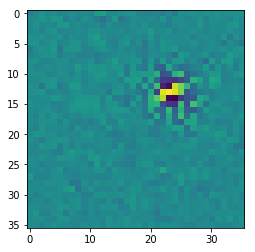

bipolar


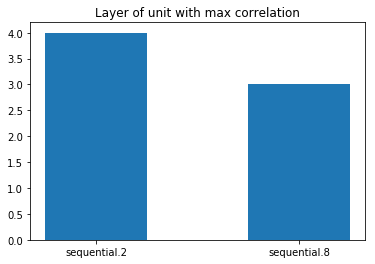

amacrine


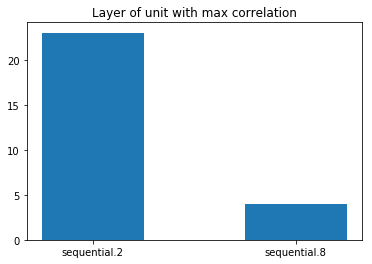

horizontal


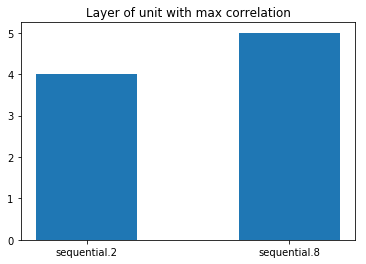

Receptive field of boxes model cell in Layer 0


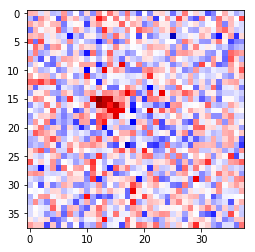

Receptive field of boxes model cell in Layer 1


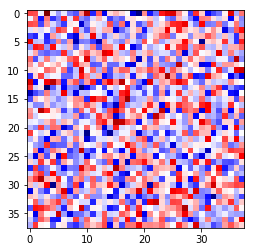

Memory Used: 8092.38 memory
Completed in 171.17299675941467 seconds





Folder: bncnnDataSearch/bncnnDataSearch_5_dataset15-11-21b_stim_typenaturalscene
Final Loss: -6.799598386744388
Final Val: -6.591351803741418
Final Val Acc: 0.24755599262083278

Final Test Acc: 0.5873056410120121


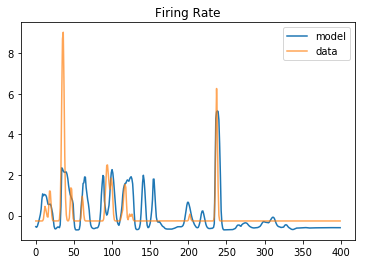

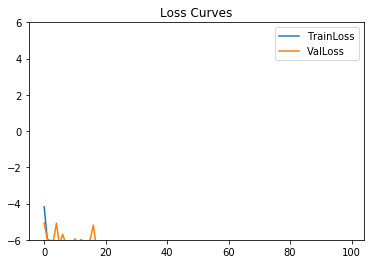

100%|██████████| 10/10 [00:00<00:00, 78.93it/s]
51it [00:00, 210.19it/s]


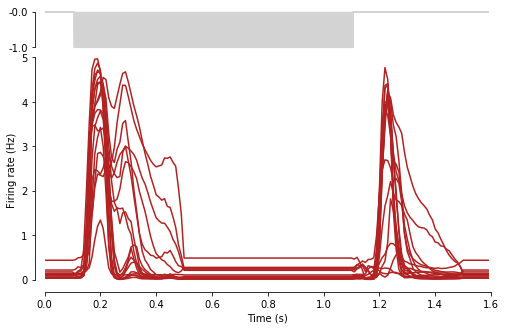

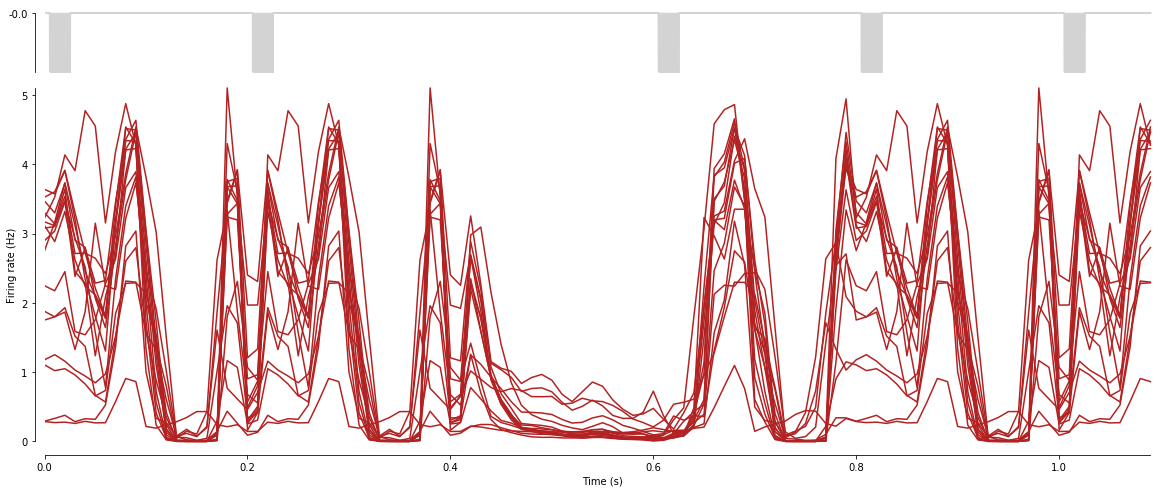

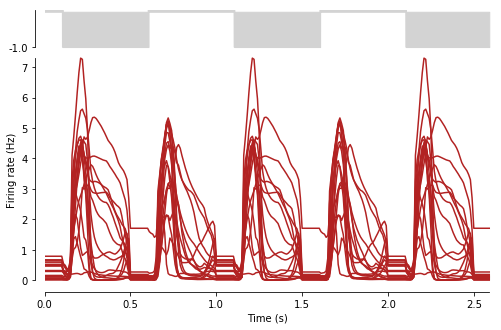

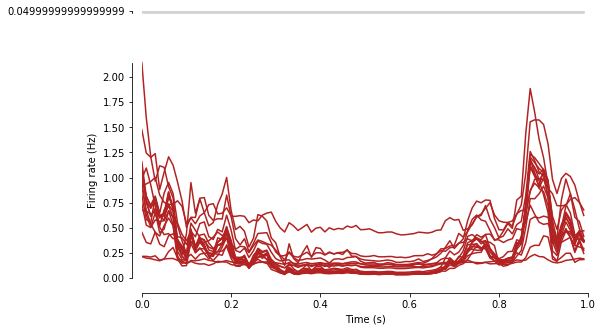

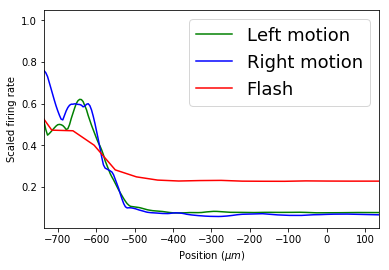

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:20<00:00, 23.60s/it]


Mean intracellular: 0.5058986893587799
Std intracellular: 0.14237471794429535
Min intracellular: 0.21519630336188947
Max intracellular: 0.7584739710930275
Layer sequential.2 correlation map


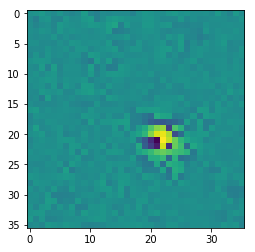

bipolar


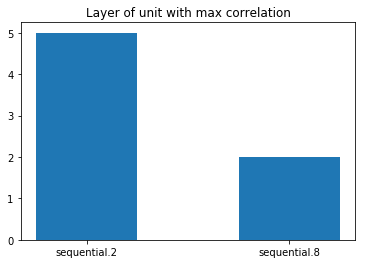

amacrine


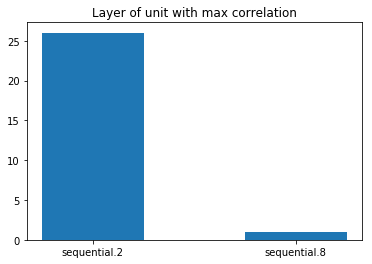

horizontal


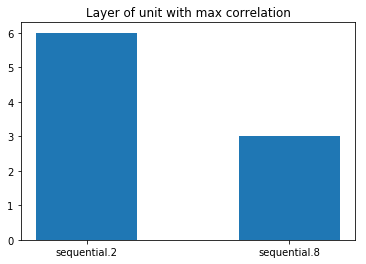

Receptive field of boxes model cell in Layer 0


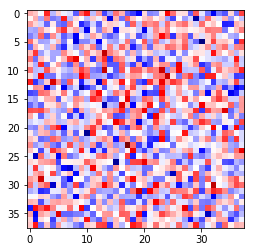

Receptive field of boxes model cell in Layer 1


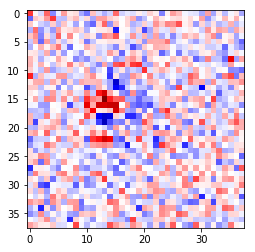

Memory Used: 8092.38 memory
Completed in 172.4845712184906 seconds





Best by validation loss: bncnnDataSearch/bncnnDataSearch_2_dataset15-11-21a_stim_typewhitenoise
Best by training loss: bncnnDataSearch/bncnnDataSearch_2_dataset15-11-21a_stim_typewhitenoise
Best by val accuracy: bncnnDataSearch/bncnnDataSearch_2_dataset15-11-21a_stim_typewhitenoise
Best by test accuracy: bncnnDataSearch/bncnnDataSearch_0_dataset15-10-07_stim_typewhitenoise
Best by intracellular correlation: bncnnDataSearch/bncnnDataSearch_3_dataset15-11-21a_stim_typenaturalscene


In [12]:
n_epochs = 250
best_folder_by_loss = ""
best_loss = 100
best_folder_by_val_loss = ""
best_val_loss = 100
best_folder_by_val_acc = ""
best_val_acc = -100
best_folder_by_test_acc = ""
best_test_acc = -100
best_folder_by_intr_cor = ""
best_intr_cor = -1

results_file_name = grand_folder + "_analysis_results.txt"
results_file = open(results_file_name, 'a')
batch_compute_size = 500

intraneuron_cors = dict()
test_accs = dict()
# load the losses
print("Using layers:", " and ".join(conv_layers))
for folder in model_folders:
    starttime = time.time()
    losses = []
    val_losses = []
    val_accs = []
    for i in range(n_epochs):
        file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
        try:
            with open(file, "rb") as fd:
                temp = torch.load(fd)
            losses.append(temp['loss'])
            val_losses.append(temp['val_loss'])
            val_accs.append(temp['val_acc'])
        except:
            break
    bn_cnn = temp['model']
    bn_cnn = bn_cnn.to(DEVICE)
    bn_cnn.eval()
    print("Folder:", folder)
    results_file.write(folder + "\n")
    print("Final Loss:", losses[-1])
    results_file.write("Final Loss:"+ str(losses[-1]) + "\n")
    print("Final Val:", val_losses[-1])
    results_file.write("Final Val:"+ str(val_losses[-1]) + "\n")
    print("Final Val Acc:", val_accs[-1])
    results_file.write("Val Acc:"+ str(val_accs[-1]) + "\n")
    if(math.isnan(losses[-1]) or math.isnan(val_losses[-1]) or math.isnan(val_accs[-1])):
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")
        continue
    
    cells = "all"
    dataset = folder.split("dataset")[-1].split("_")[0]
    stim_type = folder.split("stim_type")[-1].split("_")[0]
    try:
        norm_stats = [temp['norm_stats']['mean'], temp['norm_stats']['std']]
    except:
        norm_stats = [temp['data_norm_stats']['mean'], temp['data_norm_stats']['std']]
        assert False
    test_data = loadexpt(dataset,cells,stim_type,'test',40,0, norm_stats=norm_stats)
    test_x = torch.from_numpy(test_data.X)
    
    model_response = bc.batch_compute_model_response(test_data.X, bn_cnn, batch_compute_size, insp_keys=set(conv_layers))    
    avg_test_acc = np.mean([scipy.stats.pearsonr(model_response['output'][:, i], test_data.y[:, i])[0] for i in range(len(cells))])
    test_accs[folder] = avg_test_acc
    if math.isnan(avg_test_acc):
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")
        continue
    print("\nFinal Test Acc:", avg_test_acc)
    results_file.write("Final Test Acc:"+ str(avg_test_acc) + "\n")
    with open("../training_scripts/"+folder+"/hyperparams.txt", 'a') as f:
        f.write("\nTest Ganglion Cell Correlation: " + str(avg_test_acc))
    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_folder_by_loss = folder
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_folder_by_val_loss = folder
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        best_folder_by_val_acc = folder
    if avg_test_acc > best_test_acc:
        best_test_acc = avg_test_acc
        best_folder_by_test_acc = folder
    plt.plot(normalize(model_response['output'][:400, 0]))
    plt.plot(normalize(test_data.y[:400,0]), alpha=.7)
    plt.legend(["model", "data"])
    plt.title("Firing Rate")
    plt.show()
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["TrainLoss", "ValLoss"])
    plt.title("Loss Curves")
    plt.show()
    retinal_phenomena_figs(bn_cnn)
    plt.show()
    
    if avg_test_acc < .5 or losses[-1] > 1:
        print("Skipping further analysis due to poor results...\n\n\n\n")
        results_file.write("Skipping further analysis due to poor results...\n\n\n\n")
        continue
    print("Calculating model responses...\n")
    # Computes the model responses for each stimulus 
    # and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
    y_true = []
    filter_length = 40
    model_responses = dict()
    cell_type_keys = ['bipolar', 'amacrine', 'horizontal']
    for i in tqdm(range(len(files))):
        file_name = files[i]
        if cell_type_keys[0] in file_name:
            for j in range(num_pots[i]):
                y_true.append(0)
        elif cell_type_keys[1] in file_name:
            for j in range(num_pots[i]):
                y_true.append(1)
        elif cell_type_keys[2] in file_name:
            for j in range(num_pots[i]):
                y_true.append(2)
        for k in stims.keys():
            stim = stims[k][i]
            padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
            if k not in model_responses:
                model_responses[k] = []
            model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                      bn_cnn,batch_compute_size, 
                                                                      insp_keys=set(conv_layers)))
            # Reshape potentially flat layers
            for j,cl in enumerate(conv_layers):
                if len(model_responses[k][-1][cl].shape) <= 2:
                    try:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,36,36))
                    except:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,26,26))
    
    # uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
    # Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
    # layer that the most correlated cell is in.
    # See intracellular.py for more info
    # This takes a really long time to run. 
    print("Calculating intercellular correlations...\n")
    all_cell_info = dict()
    info_by_type = dict()
    y_pred = dict()
    for i in tqdm(range(len(files))):
        interneuron = cell_type_keys[i//2]
        for k in stims.keys():
            model_response = model_responses[k][i]
            stim = stims[k][i]
            for j in range(mem_pots[k][i].shape[0]):
                potential = mem_pots[k][i][j]
                cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                                   layer_keys=conv_layers)
                #layer, channel,(row, col), cor_coef = cell_info
                if k not in all_cell_info:
                    info_by_type[k] = dict()
                    all_cell_info[k] = []
                    y_pred[k] = []
                all_cell_info[k].append(cell_info)
                y_pred[k].append(index_of(cell_info[0], conv_layers))

    intraneuron_cors[folder] = all_cell_info
            
    # Average intracellular correlation. RIP.
    avg_intr_cor = np.mean(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Mean intracellular:", avg_intr_cor)
    results_file.write("Mean intracellular:" + str(avg_intr_cor) + "\n")
    std = np.std(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Std intracellular:", std)
    m = np.min(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Min intracellular:", m)
    results_file.write("Min intracellular:" + str(m) + "\n")
    m = np.max(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Max intracellular:", m)
    results_file.write("Max intracellular:" + str(m) + "\n")
    
    if avg_intr_cor > best_intr_cor:
        best_intr_cor = avg_intr_cor
        best_folder_by_intr_cor = folder
    
    stim_type = 'boxes'
    # Make example correlation map
    model_response = model_responses[stim_type][-1]
    potential = mem_pots[stim_type][-1][-1]
    layer, k, (i,j), r = all_cell_info[stim_type][-1]
    print("Layer", layer, "correlation map")
    plt.imshow(intracellular.correlation_map(potential, model_response[layer][:, k]))
    plt.show()

    layer_dict = {} # Tracks the number of cells that were classified to each layer in conv_layers
    # Tally layers for maximally correlated cell
    for i in range(len(y_true)):
        if y_true[i] not in layer_dict:
            layer_dict[y_true[i]] = [0 for i in range(len(conv_layers))]
        for k in y_pred.keys():
            layer_dict[y_true[i]][y_pred[k][i]] += 1

    width = 0.5
    lkeys = list(layer_dict.keys())
    ind = np.arange(0,len(conv_layers))
    for i,k in enumerate(lkeys):
        plt.bar(ind, [count for count in layer_dict[k]], width)
        plt.xticks(ind,conv_layers)
        print(cell_type_keys[i])
        plt.title("Layer of unit with max correlation")
        plt.show()
    
    stimulus_num = 3
    filter_length = 40
    for type_key in stims.keys():
        if type_key == "flashes":
            continue
        stimulus = stims[type_key][stimulus_num]
        # Plot the receptive field for a model cell
        for i,cl in enumerate(conv_layers):
            model_cell_response = model_responses[type_key][stimulus_num][cl][:, 1, 15, 15]
            print("Receptive field of", type_key,"model cell in Layer", i)
            rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, 
                                              nsamples_before=0, nsamples_after=filter_length)
            spatial_model, temporal_model = ft.decompose(rc_model)
            img = plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), 
                                                                   np.max(abs(spatial_model))])
            plt.show()
    
    gc.collect()
    max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print("Memory Used: {:.2f} memory".format(max_mem_used / 1024))
    print("Completed in", time.time()-starttime, "seconds")
    print("\n\n\n\n")
    results_file.write("\n\n\n\n")
                    
print("Best by validation loss:", best_folder_by_val_loss)
print("Best by training loss:", best_folder_by_loss)
print("Best by val accuracy:", best_folder_by_val_acc)
print("Best by test accuracy:", best_folder_by_test_acc)
print("Best by intracellular correlation:", best_folder_by_intr_cor)
results_file.close()


In [21]:
avg_cors = {k:[] for k in cell_type_keys} # keys are defined above as ['bipolar', 'amacrine', 'horizontal']
for i,all_cell_info in enumerate(inter_cors): # 1 all_cell_info for each model
    for stim_type in all_cell_info.keys(): # each stim type for the intraneuron recordings
        for j in range(len(all_cell_info[stim_type])):
            max_cor = all_cell_info[stim_type][j][-1]
            avg_cors[cell_type_keys[y_true[j]]].append(max_cor)
for k in avg_cors:
    print("Mean", k, ":", np.mean(avg_cors[k]))
grand_avg = []
for k in avg_cors:
    grand_avg += [x for x in avg_cors[k]]
print("Mean across all:", np.mean(grand_avg))

Mean bipolar : 0.45451388204406934
Mean amacrine : 0.5177433120270791
Mean horizontal : 0.3048958556030057
Mean across all: 0.46290068138294593


## Closer Look at Intracellular Correlations

In [ ]:
# Look more closely at intracellular correlations
for i in range(250):
    file = "../training_scripts/"+best_folder_by_intr_cor+"/test_epoch_{0}.pth".format(i)
    try:
        with open(file, "rb") as fd:
            temp = torch.load(fd)
    except:
        break
bn_cnn = temp['model']
# bn_cnn.load_state_dict(temp['model_state_dict']) # unnecessary
bn_cnn.to(DEVICE)
bn_cnn.eval()
# Computes the model responses for each stimulus 
# and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
y_true = []
filter_length = 40
model_responses = dict()
for i in tqdm(range(len(files))):
    file_name = files[i]
    if 'bipolar' in file_name:
        for j in range(num_pots[i]):
            y_true.append(0)
    elif 'amacrine' in file_name:
        for j in range(num_pots[i]):
            y_true.append(1)
    else:
        for j in range(num_pots[i]):
            y_true.append(2)
    for k in stims.keys():
        stim = stims[k][i]
        padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
        if k not in model_responses:
            model_responses[k] = []
        model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                  bn_cnn,batch_compute_size, 
                                                                  insp_keys=set(conv_layers)))
        # Reshape potentially flat layers
        for j,cl in enumerate(conv_layers):
            if len(model_responses[k][-1][cl].shape) <= 2:
                model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape(
                                model_responses[k][-1][conv_layers[j-1]].shape)

# uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
# Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
# layer that the most correlated cell is in.
# See intracellular.py for more info
# This takes a really long time to run. 
print("Calculating intercellular correlations...")
all_cell_info = dict()
y_pred = dict()
for i in tqdm(range(len(files))):
    for k in stims.keys():
        model_response = model_responses[k][i]
        stim = stims[k][i]
        for j in range(mem_pots[k][i].shape[0]):
            potential = mem_pots[k][i][j]
            cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                               layer_keys=conv_layers)
            #layer, channel,(row, col), cor_coef = cell_info
            if k not in all_cell_info:
                all_cell_info[k] = []
                y_pred[k] = []
            all_cell_info[k].append(cell_info)
            y_pred[k].append(index_of(cell_info[0], conv_layers))

duplicates = {}
for k in all_cell_info.keys():
    idx = 0
    for i in range(len(mem_pots)):
        for j,pot in enumerate(mem_pots[k][i]):
            layer, channel,(row, col), cor_coef = all_cell_info[k][idx]
            tup = (layer, channel, row, col)
            if tup not in duplicates:
                duplicates[tup] = 1
            else:
                duplicates[tup] += 1
            cor = np.correlate(model_responses[k][i][layer][:,channel, row, col], pot, 'full')
            print("i:", i, " - j:", j)
            print("Layer:", layer, " - Channel:", channel, " - Row:", row, " - Col:", col)
            print("Pearsonr:", cor_coef)
            plt.plot(cor)
            plt.title("Correlation")
            plt.show()
            plt.plot(normalize(model_responses[k][i][layer][:400, channel,row,col]))
            plt.plot(normalize(mem_pots[k][i][j][:400]), alpha=.7)
            plt.legend(["model", "data"])
            plt.title("Firing Rate")
            plt.show()
            print("\n\n")
            idx+=1